In [1]:
from scipy.io import wavfile
from scipy.fftpack import rfft, irfft
from scipy.signal import find_peaks
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import numpy as np
import scipy
import aubio
from collections import defaultdict
from scipy.signal import butter, lfilter, freqz
import random
%matplotlib inline

In [36]:
filename = 'do.wav'
sample_rate, channels = wavfile.read(filename)
window_size = 8192
stride = 512
data_length = channels[:, 0].shape[0]
data = (channels[:, 0] + channels[:, 1]) / 2  # todo: that's going to change
amplitude = max(max(data), -min(data))
data = list(map(lambda x: x / amplitude, data))

left = sample_rate*10
right = sample_rate*40

In [37]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a


def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def FILTERBLYAT(data, cutoff):
    # Filter requirements.
    order = 6

    # Filter the data, and plot both the original and filtered signals.
    y = butter_lowpass_filter(data, cutoff, sample_rate, order)
    return y

In [38]:
def CountEnergy(musik, sample=1024):
    E = []
    curE = 0
    for i in range(sample):
        curE += musik[i] ** 2
    for i in range(0, len(musik) - sample):
        curE += musik[i + sample] ** 2
        curE -= musik[i] ** 2
        E.append(curE)
    return E

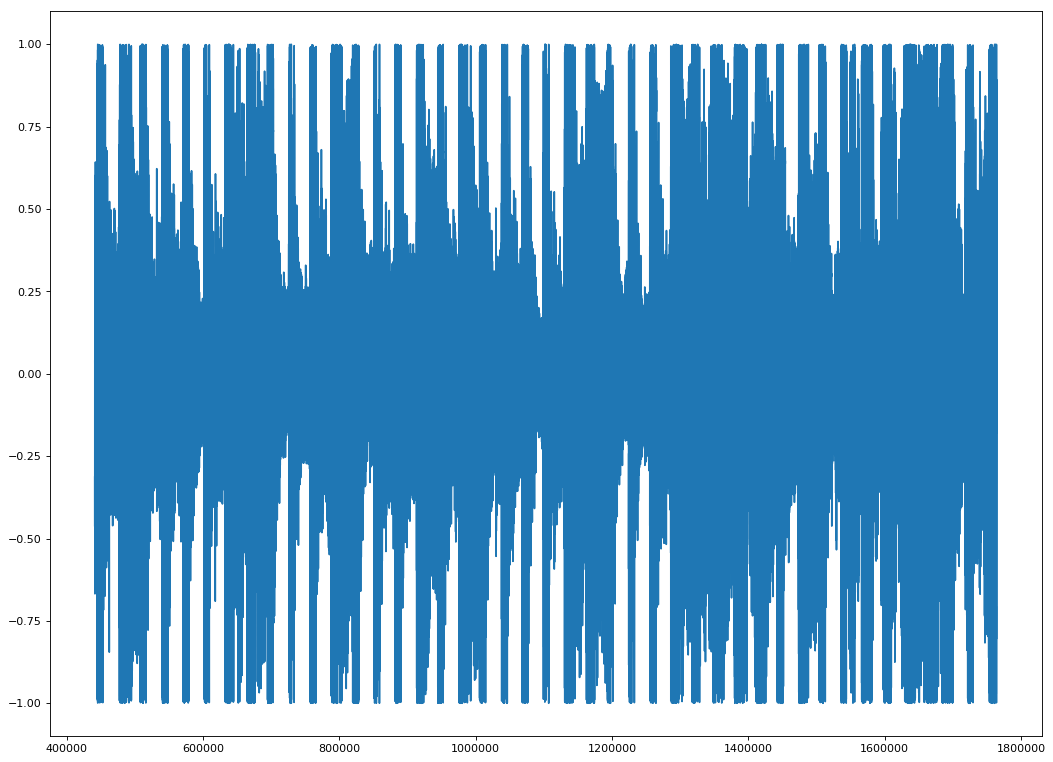

In [39]:
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(left, right), data[left:right])
plt.show()

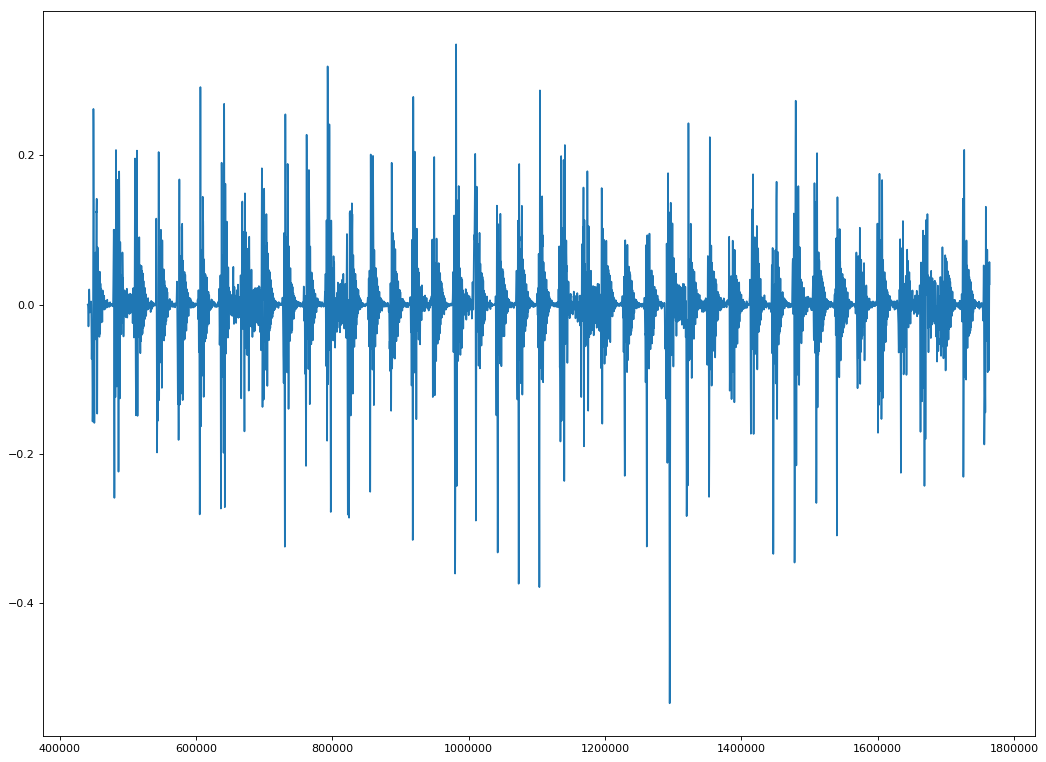

In [40]:
filtered = FILTERBLYAT(data[left:right], 30)
SAMPLEBL = 1024
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(left, right), filtered)
plt.show()

In [41]:
E = CountEnergy(filtered, SAMPLEBL)

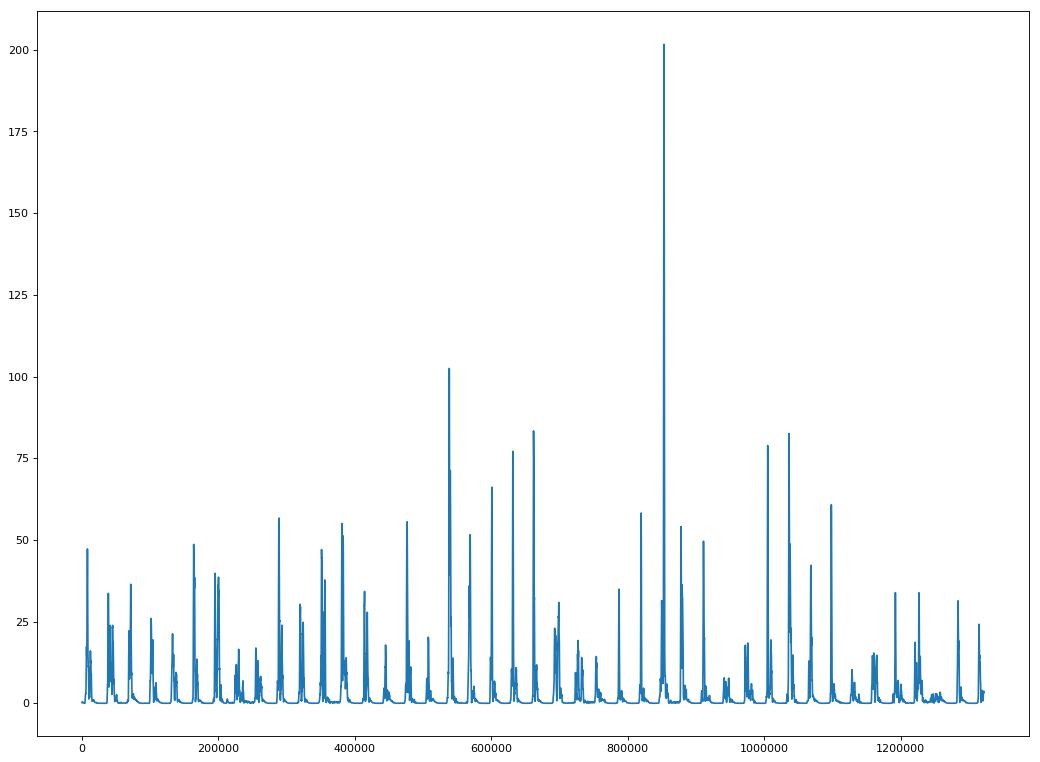

In [42]:
Elin = np.array(E)

figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(Elin)
plt.show()

In [43]:
def MAXWINDOW(arr, sample, threshold):
    stack = []
    res = []
    for i in range(0, sample):
        while len(stack) > 0 and arr[stack[-1]] < arr[i + sample]:
            stack.pop()
        stack.append(i)
    for i in range(0, len(arr) - sample):
        while len(stack) > 0 and arr[stack[-1]] < arr[i + sample]:
            stack.pop()
        stack.append(i + sample)
        value = stack[0]
        if arr[value] < threshold:
            value = 0
        res.append(arr[value])
        if stack[0] == i:
            stack.pop(0)
    return res

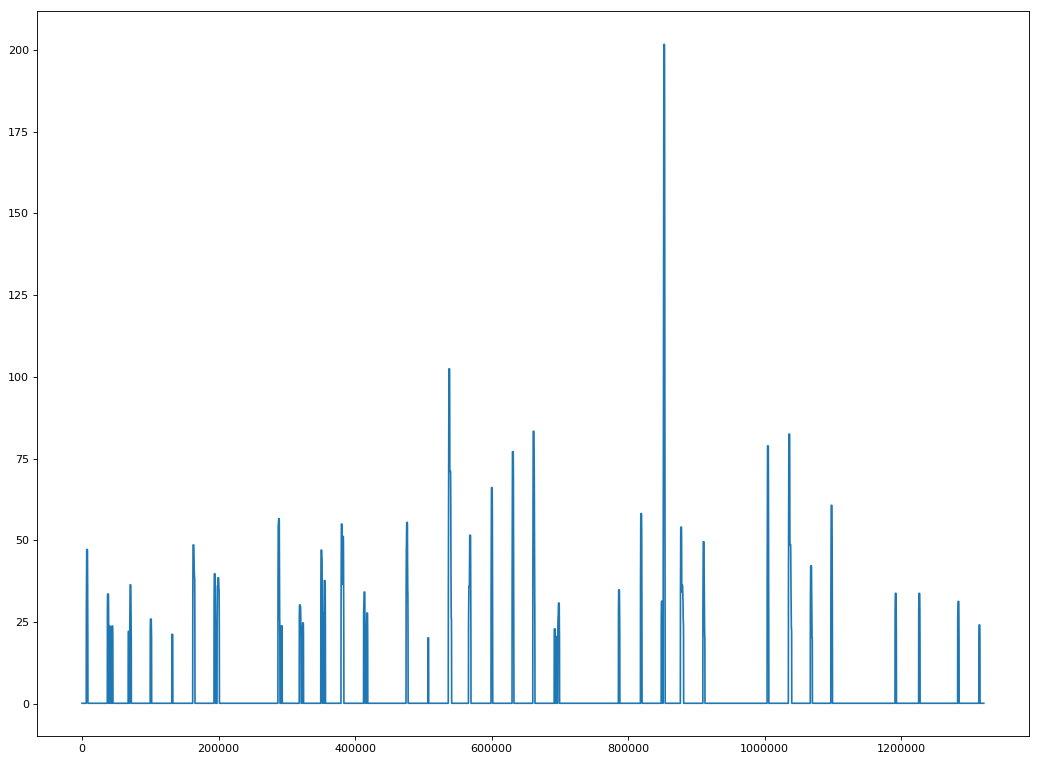

In [44]:
mxw = MAXWINDOW(Elin, SAMPLEBL, 20)
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
#mxw = Elin[mxw]
mxwlr = mxw
plt.plot(mxwlr)
plt.show()

In [45]:
def FINDPEAKS(arr, step, thres):
    i = 0
    peaks = []
    while (i < len(arr)):
        if arr[i] > thres:
            peaks.append(i)
            i += step
        i += 1
    return peaks

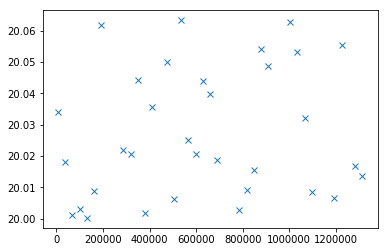

In [46]:
peaks = FINDPEAKS(mxw, sample_rate//5, 20)
#print(peaks)
peaksev = list(map(lambda x: mxw[x], peaks))
plt.plot(peaks, peaksev, "x")

In [47]:
def CNTBPM(peaks):
    bpms = []
    for i in range(60, 180):
        bpms.append(60 * sample_rate / i)

    cnt = dict()
    for i in range(len(bpms)):
        cnt[bpms[i]] = 0
    
    for i in range(len(peaks) - 1):
        a = peaks[i]
        b = peaks[i + 1]
        val = (b - a)
        while val > bpms[0]:
            val /= 2
        while val < bpms[-1]:
            val *= 2
        cbpm = 0
        for j in range(len(bpms)):
            if abs(bpms[cbpm] - val) > abs(bpms[j] - val):
                cbpm = j
                
        cnt[bpms[cbpm]] += 1
    
    srt = []
    for k, v in cnt.items():
        srt.append([v, k])
    
    srt.sort(reverse=True)
    avg = 0
    cnt = 0
    for i in range(len(srt)):
        if srt[i][0] == srt[0][0]:
            avg += srt[i][1]
            cnt += 1
    return round(60 * sample_rate / (avg / cnt))

In [48]:
BPM = CNTBPM(peaks)
print(BPM)

85


In [49]:
def GETTACTS(data, pkst, bpm, slid = 0):
    tacts = []
    smpl = 60 * sample_rate // bpm
    start = pkst
    pkst -= slid * smpl
    while start > 0:
        start -= smpl * 4
    start += smpl * 4
    for i in range(start, len(data), smpl):
        tacts.append(data[i:(i+smpl)])
    return tacts, start, smpl

def GETTACTSIND(data, start, bpm):
    tacts = []
    smpl = 60 * sample_rate // bpm
    for i in range(start, len(data), smpl):
        tacts.append(i)
    return tacts

In [50]:
peakToStart = 5
tacts, GLST, GLSM = GETTACTS(data, peaks[peakToStart], BPM)
tactsRAW, _, _ = GETTACTS(channels, peaks[peakToStart], BPM)
#tacts = GETTACTSIND(channels, peaks[1], BPM)

In [51]:
def ENERGYTACTS(tacts):
    E = []
    for i in range(0, len(tacts)):
        e = CountEnergy(tacts[i], SAMPLEBL)
        E.append(np.array(e))
    return E

In [52]:
ET = ENERGYTACTS(tacts)

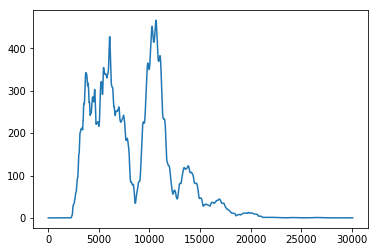

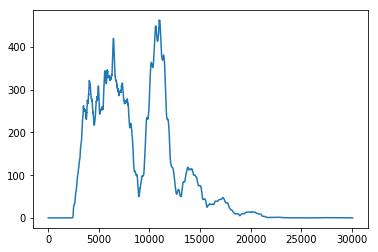

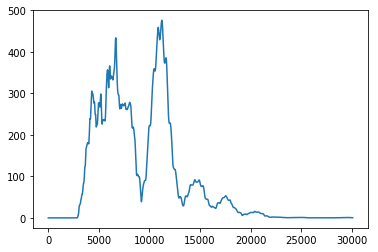

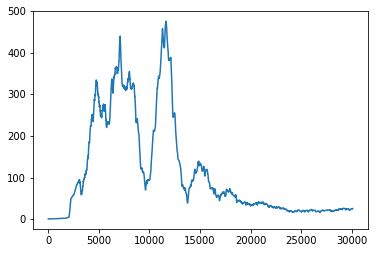

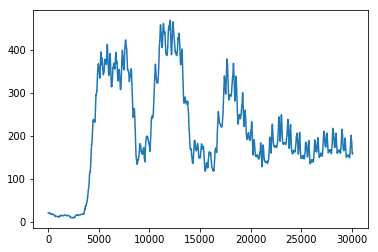

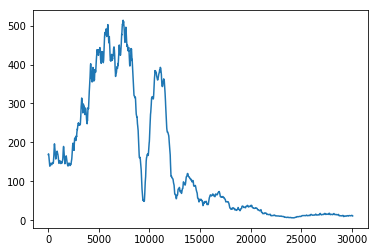

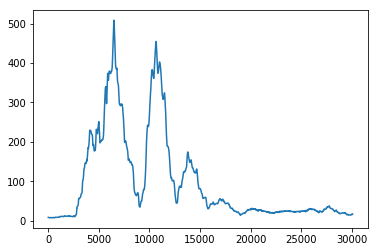

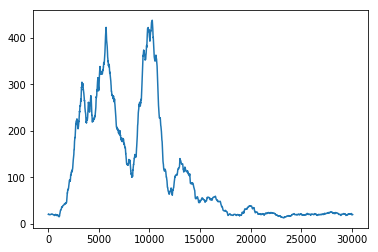

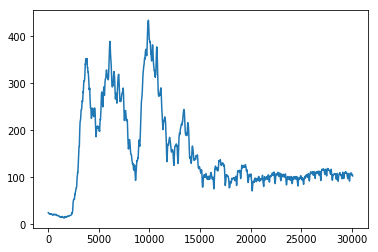

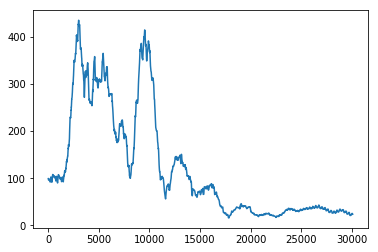

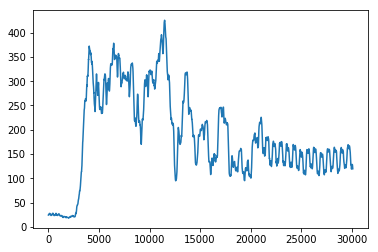

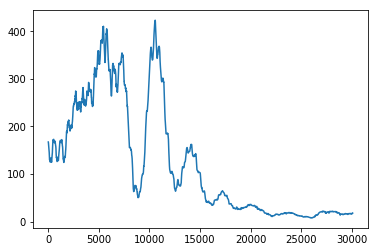

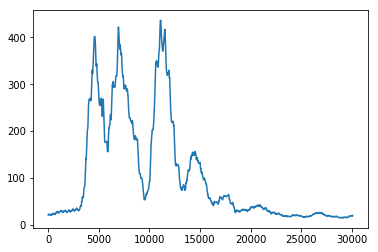

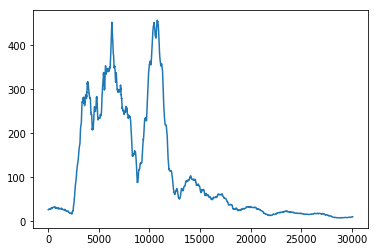

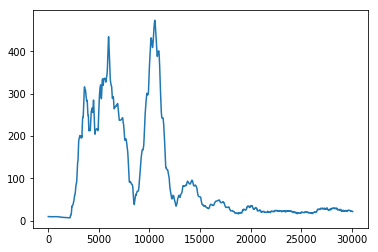

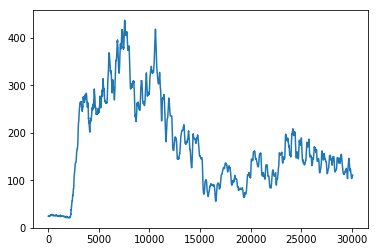

In [53]:
for i in range(4, 20):
    plt.plot(ET[i])
    plt.show()

In [54]:
def GETFFT(l, r):
    spectrum = np.abs(np.fft.fft(data[l:r], axis=0))
    return spectrum

def MSE(a):
    return (a**2).mean()

def CNTERR(a, b, l, r):
    if r + 4*GLSM >= len(data):
        return 1e9
    sa = GETFFT(l, l + 4*GLSM)
    sb = GETFFT(r, r + 4*GLSM)
    dif = np.abs(sa-sb)
    return MSE(dif)
    

def SIMILAR(E, thres):
    res = []
    for i in range(0, len(E), 4):
        for j in range(i + 4, len(E), 4):
            err = CNTERR(E[i], E[j], GLST + GLSM*i, GLST + GLSM*j)
            if err < thres:
                res.append([i, j])
                res.append([j, i])
    return res

In [55]:
GRAPH = SIMILAR(ET, 5000)

KeyboardInterrupt: 

In [ ]:
def determine(x):
    a = x[0] // 4
    b = x[1] // 4
    return a % 2 != b % 2

GRAPH = [x for x in GRAPH if not determine(x)]
print(GRAPH)

In [ ]:
npG = np.array(GRAPH)
X = npG[:,0]
Y = npG[:,1]
figure(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
plt.plot(X, Y, "x")

In [ ]:
def MAKEMUSIC(graph, tactsRAW, l):
    G = [[] for i in range(len(tactsRAW))]
    for i in range(len(G)):
        G[i].append((i+1) % len(G))
    for i in graph:
        G[i[0]-1].append(i[1])
    t = random.randint(0, len(G[-1]) - 1)
    curT = G[-1][t]
    #print(curT)
    result = np.empty((0, 2), np.int16)
    jumps = 0
    while len(result) < l:
        #print(curT)
        result = np.concatenate((result, tactsRAW[curT]))
        if len(G[curT]) == 0:
            break
        t = random.randint(0, len(G[curT]) - 1)
        if t != 0:
            jumps += 1
        curT = G[curT][t]
    print(jumps)
    return result

In [ ]:
RESULTBL = MAKEMUSIC(GRAPH, tactsRAW, 100*sample_rate)
plt.plot(RESULTBL)
plt.show()


In [ ]:
wavfile.write("res.wav", sample_rate, RESULTBL)